# Etivity 4: Classification (Carla Warde - 17204542) 
In this etivity I will be training and evaluating a few different classification models.

This will be accomplished in the following steps:
<ol>
    <li>Import data and relevant modules</li>
    <li>EDA</li>
    <li>Data Preparation</li>
    <li>Grid Search for Best Parameters of Classifiers</li>
    <li>Compare Classifiers on Test Set</li>
    <li>Train a Final Model</li>
</ol>

## 1. Import Modules and Dataset

In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, RobustScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_recall_fscore_support
from scipy import interp
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv("./seeds.csv")
df.head()

# get a copy for later use
df_copy = df

In our dataset, `type` is our <i>target</i> variable and the rest of the columns are <i>predictors</i>. Following common naming conventions, I will refer to the target as <b>X</b> and the predictors as <b>Y</b>.

## 2. EDA
Let's start by checking the dataframe for the possible values for $X$.

In [3]:
df['type'].value_counts()

3    70
2    70
1    70
Name: type, dtype: int64

We can see an even split between the different values of `type` here which is a good sign. Since the data isn't skewed towards a particular value, our models should hopefully be able to make good predictions after we train it on the dataset.

Now let's check for any missing values to ensure our data is prepared.

In [4]:
df.isna().sum()

area                       0
perimeter                  0
compactness                0
length of kernel           0
width of kernel            0
asymmetry coefficient      0
length of kernel groove    0
type                       0
dtype: int64

Thankfully, the dataset isn't missing any values. Next we'll check for outliers by using a boxplot.

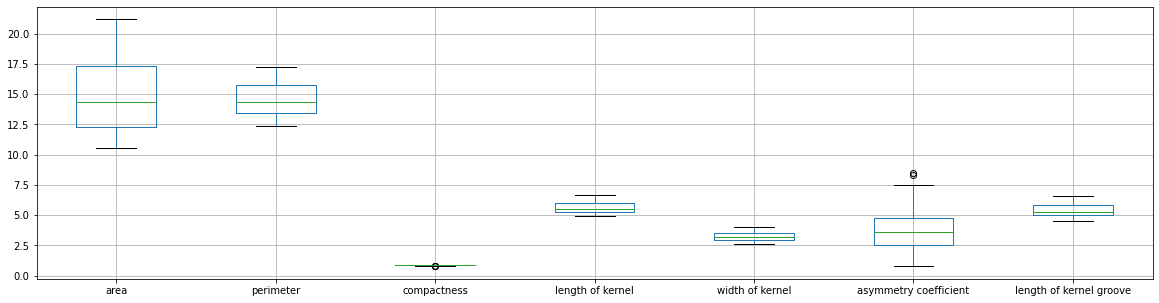

In [5]:
df.loc[:,'area':'length of kernel groove'].boxplot(figsize=(20,5))
plt.show()

As seen in the plot, there are very few outliers. Only one or two exist in `compactness` and `asymmetry coefficient`. Let's look at the mean and median of these attributes.

In [6]:
df.describe()

,area,perimeter,compactness,length of kernel,width of kernel,asymmetry coefficient,length of kernel groove,type
count,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000
mean,14.847524,14.559286,0.870999,5.628533,3.258605,3.700201,5.408071,2.000000
std,2.909699,1.305959,0.023629,0.443063,0.377714,1.503557,0.491480,0.818448
min,10.590000,12.410000,0.808100,4.899000,2.630000,0.765100,4.519000,1.000000
25%,12.270000,13.450000,0.856900,5.262250,2.944000,2.561500,5.045000,1.000000
50%,14.355000,14.320000,0.873450,5.523500,3.237000,3.599000,5.223000,2.000000
75%,17.305000,15.715000,0.887775,5.979750,3.561750,4.768750,5.877000,3.000000
max,21.180000,17.250000,0.918300,6.675000,4.033000,8.456000,6.550000,3.000000


The table shows there's a neglible difference between the mean and median for `compactness` and `asymmetry coefficient`. I argue that the means of these attributes aren't skewed by the outliers and thus a `StandardScalar` will be sufficient to scale all of the predictors. We'll also need to scale `type` to so the values are between 0 and 1.

## 3. Data Preparation
Before we scale our predictors, we need to prepare a list of column names. This is because when we split our data into training and test datasets, the column names will be lost so we need to store them.

In [7]:
# store a list with the names of all predictors
names_all = [c for c in df if c not in ['type']]

### 3.1 Construct Predictor Pre-Processing Pipline
As previously discussed, outliers are not an issue in this dataset, thus our pre-processing pipeline will be simple as all predictor columns will be treated the same. All we need to do is apply a StandardScalar to each predictor column in the pipeline.

In [8]:
class AddColumnNames(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return pd.DataFrame(data=X, columns=self.columns)

In [9]:
preprocess_pipeline = make_pipeline(
    AddColumnNames(columns=names_all),
    StandardScaler()
)

### 3.2 Transform Target
Since the aim of this etivity is to compare <i>binary</i> classifiers, we need to tranform our targe `type` since it has three possible values. I will achieve this by setting every value that is not equal to 1 to 0. This also accomplishes scaling the values between 0 and 1. Unfortunately, changing type so it has two possible values skews the dataset since there's a lot more entries of type 0, but nothing can be done about this.

In [10]:
x = df['type']
df['type'] = [0 if x_ > 1 else x_ for x_ in x]
df['type'].value_counts()

0    140
1     70
Name: type, dtype: int64

### 3.3 Split dataset
Since our data is prepared, we can now split it into predictors and target, and training test sets.

In [11]:
y = df['type']
X = df.drop('type', axis=1).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y)

## 4. Grid Search for Best Parameters of Classifiers
### 4.1 SVM Classifier
The next step is to train an SVM classifier with the training set and a range of possible parameters in order to find the best parameters for SVM by cross-validation.

To do this I will build another pipeline that contains the preprocessing pipeline and the SVM classifier.

In [19]:
# create the pipeline
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), ('svm', svm.SVC(probability=True))])

# prepare a parameter grid
# note that __ can be used to specify the name of a parameter for a specific element in a pipeline
# note also that this is not an exhaustive list of the parameters of svn.SVC and their possible values

param_grid = {
    'svm__C': [0.1, 1.0, 10.0, 30.0, 60.0, 100.0],  
    'svm__gamma': [2.0, 1.0, 0.1, 0.01, 0.001], 
    'svm__kernel': ['rbf', 'linear', 'poly', 'sigmoid'],
    # additional parameters for poly and sigmoid
    'svm__coef0': [1.0, 0.1,0.01,0.001,0],
    'svm__degree': [5,4,3,2,1]
}

search = GridSearchCV(pipe, param_grid, cv=10, iid=False, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
SVM_best_params = search.best_params_
SVM_best_model = search.best_estimator_

Best CV score = 0.958:
Best parameters:  {'svm__C': 100.0, 'svm__coef0': 1.0, 'svm__degree': 2, 'svm__gamma': 0.1, 'svm__kernel': 'poly'}


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


The best parameters for SVC were as follows:
<ul>
    <li>C: 100.0</li>
    <li>Gamma: 0.1</li>
    <li>Kernel: poly</li>
    <li>Coef0: 1.0 - Independent term in kernel function. Used in poly and sigmoid kernels.</li>
    <li>Degree: 2 - Degree of the polynomial kernel function, it's ignored by other kernels.</li>
</ul>

### 4.2 Random Forest Classifier
Let's repeat the same process with the Random Forest Classifier.

In [13]:
# create the pipeline
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), ('rf', RandomForestClassifier())])

# prepare a parameter grid
# note that __ can be used to specify the name of a parameter for a specific element in a pipeline
# note also that this is not an exhaustive list of the parameters of RandomForestClassifier and their possible values
param_grid = {
    'rf__n_estimators' : [5,10,20,30,50,100],
    'rf__max_depth': [2, 4, 6, 8, 10, None],
    'rf__min_samples_split' : [1.0,2,3,5],
    'rf__max_features' : [None, 'sqrt', 'log2']
}

search = GridSearchCV(pipe, param_grid, cv=10, iid=False, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
RF_best_params = search.best_params_
RF_best_model = search.best_estimator_

Best CV score = 0.935:
Best parameters:  {'rf__max_depth': None, 'rf__max_features': 'log2', 'rf__min_samples_split': 3, 'rf__n_estimators': 100}


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


These are the best parameters for Random Forest Classifier:
<ul>
    <li>n_estimators: 100</li>
    <li>max_depth: None</li>
    <li>min_samples_split: 3 - The minimum number of samples required to split an internal node.</li>
    <li>max_features: log2 - The number of features to consider when looking for the best split. The default value is None.</li>
</ul>

### 4.3 KNN Classifier
The third model I will be training is the KNN Classifier, also known as the K-Nearest Neighbours Classifier. The KNN Classifier begins with looking for the K nearest neighbours (the default being 5). Then among these neighbors, it counts the number of data points in each category. The new data point is then assigned to the category that had the most neighbours.

I decided to use this model since being able to test different values of K could produce interesting results. Also, the algorithm can be set up similarly to SVM and RF unlike MLP which cannot use the prepocess_pipeline.

In [14]:
# create the pipeline
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), ('knn', KNeighborsClassifier())])

# prepare a parameter grid
# note that __ can be used to specify the name of a parameter for a specific element in a pipeline
# note also that this is not an exhaustive list of the parameters of RandomForestClassifier and their possible values
param_grid = {
    'knn__n_neighbors' : [3,4,5,6,7],
    'knn__weights': ['uniform', 'distance'],
    'knn__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'knn__leaf_size': [10,20,30,40,50],
    'knn__p': [1, 2]
}

search = GridSearchCV(pipe, param_grid, cv=10, iid=False, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
KNN_best_params = search.best_params_
KNN_best_model = search.best_estimator_

Best CV score = 0.941:
Best parameters:  {'knn__algorithm': 'auto', 'knn__leaf_size': 10, 'knn__n_neighbors': 6, 'knn__p': 1, 'knn__weights': 'distance'}


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


These are the best parameters for KNN Classifier:
<ul>
    <li>n_neighbours: 6 - Number of neighbors to use for kneighbors queries. The default is 5.</li>
    <li>weights: distance - The weight function used in prediction.</li>
    <li>algorithm: auto - Algorithm used to compute the nearest neighbors:</li>
    <li>leaf_size: 10 - Leaf size passed to BallTree or KDTree.</li>
    <li>p: 1 - Power parameter for the Minkowski metric. When p = 1, this is equivalent to using manhattan_distance, and euclidean_distance for p = 2.</li>
</ul>


## 5. Compare Classifiers on Test Set

Now that the models have been trained, we can evaluate their performance on the test set by comparing a series of metrics:

- accuracy
- precisions
- recall
- F1-score
- TPR (true positive rate)
- AUC (area under the ROC curve)

To plot ROC curves we have to ensure the same false positive rate scale is used for all models. This is why I'll create a scale of 100 equally spaced false positive values between 0 and 1.

In [15]:
mean_fpr = np.linspace(start=0, stop=1, num=100)

Now we need a function that can evaluate the perforance of the models.

In [16]:
# model - a trained binary probabilistic classification model;
#         it is assumed that there are two classes: 0 and 1
#         and the classifier learns to predict probabilities for the examples to belong to class 1

def evaluate_model(X_test, y_test, model):
    # compute probabilistic predictiond for the evaluation set
    _probabilities = model.predict_proba(X_test)[:, 1]
    
    # compute exact predictiond for the evaluation set
    _predicted_values = model.predict(X_test)
        
    # compute accuracy
    _accuracy = accuracy_score(y_test, _predicted_values)
        
    # compute precision, recall and f1 score for class 1
    _precision, _recall, _f1_score, _ = precision_recall_fscore_support(y_test, _predicted_values, labels=[1])
    
    # compute fpr and tpr values for various thresholds 
    # by comparing the true target values to the predicted probabilities for class 1
    _fpr, _tpr, _ = roc_curve(y_test, _probabilities)
        
    # compute true positive rates for the values in the array mean_fpr
    _tpr_transformed = np.array([interp(mean_fpr, _fpr, _tpr)])
    
    # compute the area under the curve
    _auc = auc(_fpr, _tpr)
            
    return _accuracy, _precision[0], _recall[0], _f1_score[0], _tpr_transformed, _auc

To evaluate the models, I'll call the function for each model and then plot the data on a bar chart.

In [17]:
SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score, SVM_tpr, SVM_auc = evaluate_model(X_test, y_test, SVM_best_model)
RF_accuracy, RF_precision, RF_recall, RF_f1_score, RF_tpr, RF_auc = evaluate_model(X_test, y_test, RF_best_model)
KNN_accuracy, KNN_precision, KNN_recall, KNN_f1_score, KNN_tpr, KNN_auc = evaluate_model(X_test, y_test, KNN_best_model)

<ipython-input-16-e712ba2ef97f>:23: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  _tpr_transformed = np.array([interp(mean_fpr, _fpr, _tpr)])
<ipython-input-16-e712ba2ef97f>:23: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  _tpr_transformed = np.array([interp(mean_fpr, _fpr, _tpr)])
<ipython-input-16-e712ba2ef97f>:23: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  _tpr_transformed = np.array([interp(mean_fpr, _fpr, _tpr)])


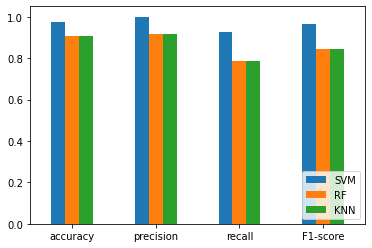

In [18]:
SVM_metrics = np.array([SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score])
RF_metrics = np.array([RF_accuracy, RF_precision, RF_recall, RF_f1_score])
KNN_metrics = np.array([KNN_accuracy, KNN_precision, KNN_recall, KNN_f1_score])
index = ['accuracy', 'precision', 'recall', 'F1-score']
df_metrics = pd.DataFrame({'SVM': SVM_metrics, 'RF': RF_metrics, 'KNN': KNN_metrics}, index=index)
df_metrics.plot.bar(rot=0)
plt.legend(loc="lower right")
plt.show()

The following can be noted from the above bar chart:

- SVM consistently scores the highest in each category
- RF and KNN have the same results in each category

Thus it can be concluded that SVM is the best classifier since it outperforms the other two in every category.

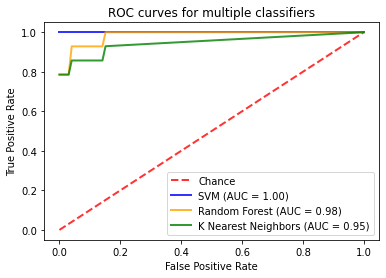

In [20]:
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=0.8)
plt.plot(mean_fpr, SVM_tpr[0,:], lw=2, color='blue', label='SVM (AUC = %0.2f)' % (SVM_auc), alpha=0.8)
plt.plot(mean_fpr, RF_tpr[0,:], lw=2, color='orange', label='Random Forest (AUC = %0.2f)' % (RF_auc), alpha=0.8)
plt.plot(mean_fpr, KNN_tpr[0,:], lw=2, color='green', label='K Nearest Neighbors (AUC = %0.2f)' % (KNN_auc), alpha=0.8)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves for multiple classifiers')
plt.legend(loc="lower right")
plt.show()

The ROC curve supports the conclusion that the SVM is the best classifier since it has an AUC of 1.0. It also reveals that RF peformed better than KNN overall despite having the same result as KNN in the rest of the metrics, since it's AUC is 0.98 and KNN is 0.95.

## 6. Train a Final Model

Now that it's been established that SVC is the best classifier, I can train the final model based on the the parameters selected earlier. Then I'll use pickle to save a copy of the model.

In [21]:
# function to remove the string 'svm__' from the names of the parameters in SVM_best_params
def transform(dict):
    return {key.replace('svm__','') :  value for key, value in dict.items()}

pipe = make_pipeline(preprocess_pipeline, svm.SVC(**transform(SVM_best_params)))

final_model =pipe.fit(X, y)

In [22]:
filename = 'final_model.sav'
pickle.dump(final_model, open(filename, 'wb'))